# Taichi - 11.06.2024
## Auteurs
- Miguel Jalube
- Romain Humair
## Description
Taichi est un langage de programmation intégré à python qui permet d'écrire du code hautement performant en utilisant le parrallélisme et la vectorisation. Il est principalement utilisé pour la simulation physique, la rendu d'image et l'apprentissage profond. Taichi est conçu pour être facile à utiliser et à apprendre, il est également très flexible et extensible. Il est open source et est disponible sur github.

Taichi fait du code parallele automatique, ce qui veut dire que le developpeur n'a pas besoin de spécifier quoi que ce soit, juste ajouter l'annotation @ti.kernel à la fonction qu'il veut paralléliser.

## Installation
Pour installer taichi, il suffit d'exécuter la commande suivante:
```bash
$ pip install taichi -U
```

In [57]:

!pip install taichi -U
!pip install requests pillow matplotlib numpy

import time
import taichi as ti
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Comparaison des gains en performances

### Code recursif
Pour commencer nous allons comparer les performances de taichi avec python sur un code récursif. Nous allons calculer le n-ième nombre de fibonacci.

In [62]:
# Valeur de fibonacci a calculer
value = 39

#### Vanilla fibonacci

In [64]:
def fib(n : int) -> int:
    if n < 2:
        return n
    return fib(n-1) + fib(n-2)

start_time = time.time()
result = fib(value)
end_time = time.time()

print(f"fib({value}) = {result}")
print(f"Time: {end_time - start_time:.6f}s")



fib(39) = 63245986
Time: 10.63s


#### Taichi Fibonacci

In [65]:
ti.init(arch=ti.cpu)

@ti.kernel
def fib_ti(n : int) -> int:
    res = n
    if n > 2:
        res = fib_ti(n-1) + fib_ti(n-2)
    return res

start_time = time.time()
result = fib_ti(value)
end_time = time.time()

print(f"fib_ti({value}) = {result}")
print(f"Time: {end_time - start_time:.6f}s")


[Taichi] Starting on arch=x64


TaichiSyntaxError: 
File "/tmp/ipykernel_9504/869410381.py", line 7, in fib_ti:
        res = fib_ti(n-1) + fib_ti(n-2)
              ^^^^^^^^^^^

Kernels cannot call other kernels. I.e., nested kernels are not allowed. Please check if you have direct/indirect invocation of kernels within kernels. Note that some methods provided by the Taichi standard library may invoke kernels, and please move their invocations to Python-scope. (<string>)

#### Résultats
Taichi ne permet pas l'utilisation de code récursif directement, il faut donc utiliser une approche itérative pour obtenir des résultats.



### Code itératif
Nous allons maintenant comparer les performances de taichi avec python sur un code itératif. Nous allons calculer le n-ième nombre de fibonacci en utilisant une boucle.

In [80]:
# Valeur de fibonacci a calculer
value = 10

#### Vanilla fibonacci itératif

In [89]:
def fib_iteratif (n : int) -> int:
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + b
    return a

start_time = time.time()
result = fib_iteratif(value)
end_time = time.time()

print(f"fib_iteratif({value}) = {result}")
print(f"Time: {end_time - start_time:.6f}s")

fib_iteratif(10) = 55
Time: 0.000046s


#### Taichi Fibonacci itératif

In [91]:
@ti.kernel
def fib_iteratif_ti(n : int) -> int:
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + b
    return a

start_time = time.time()
result = fib_iteratif_ti(value)
end_time = time.time()

print(f"fib_iteratif({value}) = {result}")
print(f"Time: {end_time - start_time:.6f}s")

fib_iteratif(10) = 1
Time: 0.002961s


#### Résultats
Il a été impossible de comparer les gains, car le code taichi ne donne pas le résultat correct, il semble y avoir un problème d'overflow. Taichi semble avoir beaucoup de mal avec les types de données contrairement à python de base qui n'est pas typé.

### Traitement d'image
Nous allons maintenant comparer les performances de taichi avec python sur un traitement d'image. Nous allons appliquer un filtre de convolution sur une image.

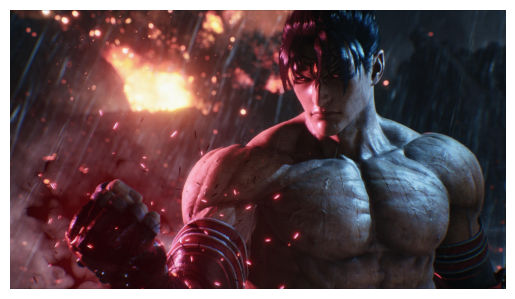

In [74]:
# variables globales

# l'imge est en 4k
url = "https://images7.alphacoders.com/127/1272410.jpg"

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img
    
# afficher une image depuis le repertoire local courant
def display_image_from_local(filename):
    img = Image.open(filename)
    # sans les axes
    plt.axis('off')
    plt.imshow(np.array(img), cmap='gray')
    plt.show()
    
# enregistrer l'image
def save_image(image, filename):
    image.save(filename)
    
# Charger l'image
image = load_image_from_url(url)

# Sauvegarder l'image
save_image(image, "../images/image.jpg")

display_image_from_local("../images/image.jpg")

#### Vanilla grayscale
Nous allons tranformer une image rgb en image en niveaux de gris.

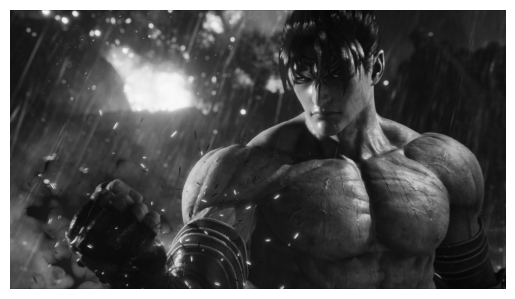

Temps de conversion: 0.078624s


In [75]:
def to_greyscale(image):
    # Convertir l'image en tableau numpy
    img_array = np.array(image)
    
    # Vérifier si l'image a une couche alpha (RGBA) et l'enlever si c'est le cas
    if img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]
    
    # Utiliser la formule de luminance pour convertir en niveaux de gris
    greyscale_array = 0.299 * img_array[:, :, 0] + 0.587 * img_array[:, :, 1] + 0.114 * img_array[:, :, 2]
    
    # Convertir le tableau numpy en image PIL
    greyscale_image = Image.fromarray(greyscale_array.astype('uint8'))
    
    return greyscale_image

# Convertir en niveaux de gris manuellement
start_time = time.time()
greyscale_image = to_greyscale(image)
end_time = time.time()

save_image(greyscale_image, "../images/vanila_greyscale.jpg")

display_image_from_local("../images/vanila_greyscale.jpg")

# Temps de conversion
print(f"Temps de conversion: {end_time - start_time:.6f}s")

#### Taichi grayscale
Maintenant nous allons faire la même chose avec taichi.

[Taichi] Starting on arch=vulkan


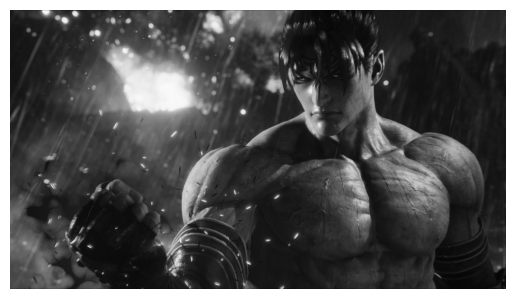

Temps de conversion: 0.059296s


In [76]:
# init taichi
import taichi as ti

ti.init(arch=ti.gpu)

def to_greyscale_ti(image):
    # Convertir l'image en tableau numpy
    img_array = np.array(image)
    
    # Vérifier si l'image a une couche alpha (RGBA) et l'enlever si c'est le cas
    if img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]
    
    # Dimensions de l'image
    h, w, c = img_array.shape
    
    # Définir les champs Taichi pour l'image couleur et l'image en niveaux de gris
    color_image = ti.Vector.field(3, dtype=ti.u8, shape=(h, w))
    greyscale_image = ti.field(dtype=ti.u8, shape=(h, w))
    
    # Copier les données de l'image couleur dans le champ Taichi
    color_image.from_numpy(img_array)
    
    # Kernel Taichi pour convertir l'image en niveaux de gris
    @ti.kernel
    def to_greyscale():
        for i, j in ti.ndrange(h, w):
            r = color_image[i, j][0]
            g = color_image[i, j][1]
            b = color_image[i, j][2]
            grey = ti.u8(0.299 * r + 0.587 * g + 0.114 * b)
            greyscale_image[i, j] = grey
    
    # Exécuter le kernel
    to_greyscale()
    
    # Convertir le champ Taichi en tableau numpy
    greyscale_array = greyscale_image.to_numpy()
    
    # Convertir le tableau numpy en image PIL
    greyscale_image_pil = Image.fromarray(greyscale_array)
    
    return greyscale_image_pil

# Convertir en niveaux de gris manuellement
start_time = time.time()
greyscale_image_ti = to_greyscale_ti(image)
end_time = time.time()

# enregistrer l'image
save_image(greyscale_image_ti, "../images/taichi_greyscale.jpg")

display_image_from_local("../images/taichi_greyscale.jpg")

# Temps de conversion
print(f"Temps de conversion: {end_time - start_time:.6f}s")

#### Résultats
Il y a un léger gain de performance avec taichi pour la transformation en greyscale d'une image 4k.

## Conclusion

Voici un tableau récapitulatif des gains de performances avec taichi:

| Code | temps d'exécution python [s] | temps d'exécution taichi [s] | gain [s] // [%] | Résultat |
|------|--------------------------|-------------------------|------|----------|
| Fibonacci récursif | 10.63 | - | - | Taichi ne tolère pas le récursif |
| Fibonacci itératif | 0.000046 | 0.002961 | - | Résultat incorrect |
| Greyscale | 0.078624 | 0.059296 | 0.019328 // 24.6 | Correct |

Taichi semble être un outil très puissant pour le calcul parallèle et la vectorisation, mais il semble avoir des problèmes avec les types de données et les calculs itératifs. Il est donc difficile de comparer les gains de performances avec python de base. L'utilisation de Taichi est plus adaptée à du traitement graphique ou calcul vectoriel.